In [1]:
import os
import time
import collections
import random
from tqdm import tqdm
from typing import Tuple, Any, Optional
import copy

import gymnasium as gym
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt

In [2]:
class PPO_Clip_Agent():
    """ Since the discrete actions have been redefined as {0,1} by env, we can simply represent the action by a number. """
    def __init__(self,
                 episode_recorder:object,
                 actor_network:torch.nn, 
                 critic_network:torch.nn,
                 actor_optimizer:torch.optim,
                 critic_optimizer:torch.optim,
                 gamma:float = 0.9,
                 advantage_lambda:float = 0.95,
                 clip_epsilon:float = 0.2, 
                 train_iters:int = 10, 
                 device:torch.device = torch.device("cpu")
                 ) -> None:
        
        self.device = device
        self.episode_recorder = episode_recorder
        self.actor_network = actor_network
        self.critic_network = critic_network
        self.actor_optimizer = actor_optimizer
        self.critic_optimizer = critic_optimizer              
        self.clip_epsilon = clip_epsilon
        self.train_iters = train_iters
        self.gamma = gamma
        self.advantage_lambda = advantage_lambda
        
    def get_action(self, obs:np.ndarray) -> int:
        obs = torch.tensor(obs, dtype = torch.float32).to(self.device)
        dist = self.actor_network(obs) # NN_outputs -softmax-> Action distribution
        dist = F.softmax(dist, dim = 0) 
        action_probs = torch.distributions.Categorical(dist)
        picked_action = action_probs.sample()
                       
        return picked_action.item()
    
    def calculate_log_prob(self, obs:torch.tensor, action:torch.tensor) -> torch.tensor:
        dist = F.softmax(self.actor_network(obs), dim=1)
        log_prob = torch.log(dist.gather(1, action))
        
        return log_prob
        
    def calculate_advantage(self, td_error:torch.tensor) -> torch.tensor:
        """ The advantage function is calculated by the TD error. """
        td_error = td_error.cpu().detach().numpy()
        advantage_list = []
        advantage = 0.0
        for delta in td_error[::-1]:
            advantage = self.gamma * self.advantage_lambda * advantage + delta
            advantage_list.append(advantage)
        advantage_list.reverse()
        advantage = torch.tensor(np.array(advantage_list), dtype = torch.float32).to(self.device)
        
        return advantage
    
    def train_policy(self) -> None:
        obs, action, reward, next_obs , done, = self.episode_recorder.get_trajectory()
        TD_target = reward + self.gamma * self.critic_network(next_obs) * (1 - done)
        TD_error = TD_target - self.critic_network(obs)
        advantage = self.calculate_advantage(TD_error)
        
        old_log_prob = self.calculate_log_prob(obs,action).detach() # Freeze the log_prob obtained by the current policy
        
        for _ in range(self.train_iters):
            critic_loss = torch.mean(F.mse_loss(TD_target.detach(), self.critic_network(obs)))
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()
            
            log_prob = self.calculate_log_prob(obs, action)
            ratio = torch.exp(log_prob - old_log_prob) # pi_theta / pi_theta_old
            clipped_ratio = torch.clamp(ratio, 1-self.clip_epsilon, 1+self.clip_epsilon)
            actor_loss = torch.mean(-torch.min(ratio * advantage, clipped_ratio * advantage))
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()
            

class Actor_Network(torch.nn.Module):

    def __init__(self,obs_dim:int,action_dim:int) -> None:
        super(Actor_Network, self).__init__()
        self.fc1 = torch.nn.Linear(obs_dim,64)
        self.fc2 = torch.nn.Linear(64,action_dim)
                    
    def forward(self,x:torch.tensor) -> torch.tensor:
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
                
        return x
    
    
class Critic_Network(torch.nn.Module):

    def __init__(self,obs_dim:int) -> None:
        super(Critic_Network, self).__init__()
        self.fc1 = torch.nn.Linear(obs_dim,64)
        self.fc2 = torch.nn.Linear(64,1)
                    
    def forward(self,x:torch.tensor) -> torch.tensor:
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
                
        return x
    

class Episode_Recorder():
    
    def __init__(self, device:torch.device = torch.device("cpu")) -> None:
        self.device = device
        self.reset()
        
    def append(self, 
               obs: np.ndarray,
               action: int,
               reward:float,
               next_obs: np.ndarray,
               done: bool
               ) -> None:
        obs = torch.tensor(np.array([obs]), 
                           dtype = torch.float32).to(self.device)
        action = torch.tensor(np.array([[action]]), 
                              dtype = torch.int64).to(self.device)
        reward = torch.tensor(np.array([[reward]]), 
                              dtype = torch.float32).to(self.device)
        next_obs = torch.tensor(np.array([next_obs]), 
                                dtype = torch.float32).to(self.device)
        done = torch.tensor(np.array([[done]]), 
                            dtype = torch.float32).to(self.device)
        self.trajectory["obs"] = torch.cat((self.trajectory["obs"], obs))
        self.trajectory["action"] = torch.cat((self.trajectory["action"], action))
        self.trajectory["reward"] = torch.cat((self.trajectory["reward"], reward))
        self.trajectory["next_obs"] = torch.cat((self.trajectory["next_obs"], next_obs))
        self.trajectory["done"] = torch.cat((self.trajectory["done"], done))
        
        
    def get_trajectory(self) -> Tuple[torch.tensor, torch.tensor, torch.tensor, torch.tensor, torch.tensor, torch.tensor]:
        
        return self.trajectory["obs"], self.trajectory["action"], \
            self.trajectory["reward"], self.trajectory["next_obs"], self.trajectory["done"]
    
    def reset(self) -> None:
        """ Clear the trajectory when begin a new episode."""
        self.trajectory = {
            "obs": torch.tensor([], dtype = torch.float32).to(self.device),
            "action": torch.tensor([], dtype = torch.int64).to(self.device),
            "reward": torch.tensor([], dtype = torch.float32).to(self.device),
            "next_obs": torch.tensor([], dtype = torch.float32).to(self.device),
            "done": torch.tensor([], dtype = torch.float32).to(self.device)
        }
        
    def add_reward(self, reward:np.ndarray) -> None:
        self.trajectory["reward"] = torch.tensor(reward, dtype=torch.float32).to(self.device)
  

In [3]:
class ReplayBuffer():
    """Expert experience collector"""
    def __init__(
        self, 
        capacity:int, 
        device:torch.device = torch.device("cpu")
    ) -> None:
        self.device = device
        self.buffer = collections.deque(maxlen=capacity)
        
    def append(self,exp_data:tuple) -> None:
        self.buffer.append(exp_data)
        
    def sample(self,batch_size:int) -> Tuple[torch.tensor,torch.tensor]:
        batch_size = min(batch_size, len(self.buffer)) # in case the buffer is not enough        
        mini_batch = random.sample(self.buffer,batch_size)
        obs_batch, action_batch = zip(*mini_batch)
        obs_batch = torch.tensor(np.array(obs_batch),dtype=torch.float32,device=self.device)
        action_batch = torch.tensor(np.array(action_batch),dtype=torch.int64,device=self.device) 
          
        return obs_batch, action_batch
    
    def fetch_all(self) -> Tuple[torch.tensor,torch.tensor]:
        obs_batch, action_batch = zip(*self.buffer)
        obs_batch = torch.tensor(np.array(obs_batch),dtype=torch.float32,device=self.device)
        action_batch = torch.tensor(np.array(action_batch),dtype=torch.int64,device=self.device) 
          
        return obs_batch, action_batch
    
    def release(self) -> None:
        self.buffer.clear()
        
    def __len__(self) -> int:
        return len(self.buffer)

In [4]:
class GAIL():
    def __init__(
        self,
        agent:Any,
        action_dim:int,
        d_network:torch.nn,
        d_optimizer:torch.optim
    ) -> None:
        self.d_network = d_network
        self.d_optimizer = d_optimizer
        self.action_dim = action_dim
        self.agent = agent
        
    def train_d(
        self, 
        exp_obs:np.ndarray,
        exp_action:np.ndarray, 
        agent_obs:np.ndarray, 
        agent_action:np.ndarray
    ) -> np.ndarray:
        exp_action = F.one_hot(exp_action.to(torch.int64), num_classes=self.action_dim).to(torch.float32).squeeze()
        agent_action = F.one_hot(agent_action.to(torch.int64), num_classes=self.action_dim).to(torch.float32).squeeze()
        exp_prob = self.d_network(exp_obs, exp_action)
        agent_prob = self.d_network(agent_obs, agent_action)
        loss = torch.nn.BCELoss()(
            agent_prob, torch.ones_like(agent_prob)) + torch.nn.BCELoss()(
                exp_prob, torch.zeros_like(exp_prob))
            
        self.d_optimizer.zero_grad()
        loss.backward()
        self.d_optimizer.step()
        gail_reward = -torch.log(agent_prob).detach().cpu().numpy()
        
        return gail_reward
        
    
class Discriminator(torch.nn.Module):
    def __init__(self, obs_dim:int, action_dim:int) -> None:
        super(Discriminator, self).__init__()
        self.fc1 = torch.nn.Linear(obs_dim + action_dim, 64)
        self.fc2 = torch.nn.Linear(64, 1)

    def forward(self, x:torch.tensor, a:torch.tensor) -> torch.tensor:
        cat = torch.cat([x, a], dim=1)
        x = F.relu(self.fc1(cat))
        return torch.sigmoid(self.fc2(x))

In [5]:
class TrainManager():
    def __init__(
        self,
        train_env:gym.Env,
        test_env:gym.Env,
        ppo_train_episode_num:int = 1000,
        actor_lr:float = 1e-3,
        critic_lr:float = 1e-2,
        gamma:float = 0.9,
        advantage_lambda:float = 0.95,
        clip_epsilon:float = 0.2,
        ppo_train_iters:int = 10,
        gail_train_episode_num:int = 1000,
        buffer_capacity:int = 10000,
        d_lr:float = 1e-4,
        test_iters:int = 5,
        seed:Optional[int] = None,
        device:torch.device = torch.device("cpu")
    ) -> None:
        # Envs
        self.train_env = train_env
        self.test_env = test_env
        self.obs_dim = gym.spaces.utils.flatdim(train_env.observation_space) 
        self.action_dim = train_env.action_space.n
        self.device = device
        # Seeds
        _,_ = self.train_env.reset(seed=seed) # Seed for training
        _,_ = self.test_env.reset(seed=seed+1)
        random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        np.random.seed(seed)
        torch.backends.cudnn.deterministic = True
        # Expert PPO
        self.ppo_train_episode_num = ppo_train_episode_num
        episode_recorder = Episode_Recorder(device = self.device)
        actor_network = Actor_Network(self.obs_dim,self.action_dim).to(self.device)
        actor_optimizer = torch.optim.Adam(actor_network.parameters(),lr=actor_lr)
        critic_network = Critic_Network(self.obs_dim).to(self.device)
        critic_optimizer = torch.optim.Adam(critic_network.parameters(),lr=critic_lr)
        self.agent = PPO_Clip_Agent(episode_recorder = episode_recorder,
                                    actor_network = actor_network, 
                                    critic_network = critic_network,
                                    actor_optimizer = actor_optimizer,
                                    critic_optimizer = critic_optimizer,
                                    gamma = gamma,
                                    advantage_lambda = advantage_lambda,
                                    clip_epsilon = clip_epsilon,
                                    train_iters = ppo_train_iters,
                                    device = self.device
                                    )
        # GAIL
        self.gail_train_episode_num = gail_train_episode_num
        gail_agent = copy.deepcopy(self.agent)                         
        self.buffer = ReplayBuffer(capacity=buffer_capacity, device=self.device)
        d_network = Discriminator(self.obs_dim, self.action_dim).to(self.device)
        d_optimizer = torch.optim.Adam(d_network.parameters(),lr=d_lr)
        self.gail = GAIL(agent = gail_agent, action_dim=self.action_dim,d_network=d_network,d_optimizer=d_optimizer)
        self.test_iters = test_iters
        
        self.test_returns_mean = []
        self.test_returns_max = []
        self.test_returns_min = []
        
        pass
    
    def train_ppo(self) -> None:
        self.episode_total_rewards = np.zeros(self.ppo_train_episode_num)
        self.index_episode = 0
        tic = time.perf_counter()  # start clock
        with tqdm(total=self.ppo_train_episode_num, desc='ExpertPPO_Training') as pbar:
            for e in range(self.ppo_train_episode_num):
                episode_reward = self.train_ppo_episode()
                toc = time.perf_counter()
                pbar.set_postfix({"Training time": f"{toc - tic:0.2} seconds", "Return": (episode_reward)})
                pbar.update(1)
        
    def train_ppo_episode(self) -> float:
        total_reward = 0
        self.agent.episode_recorder.reset()
        obs,_ = self.train_env.reset() 
        while True:
            action = self.agent.get_action(obs) 
            next_obs, reward, terminated, truncated, _ = self.train_env.step(action)
            done = terminated or truncated
            self.agent.episode_recorder.append(obs, action, reward, next_obs, done)
            total_reward += reward 
            obs = next_obs              
            if done:
                self.episode_total_rewards[self.index_episode] = total_reward
                self.index_episode += 1
                break
        
        self.agent.train_policy()
        
        return total_reward
        
    def sample_expert_data(self, n_episode:int, n_samples:int) -> None:
        for _ in range(n_episode):
            obs,_ = self.train_env.reset()
            done = False
            while not done:
                action = self.agent.get_action(obs)
                next_obs, _, terminated, truncated, _ = self.train_env.step(action)
                done = terminated or truncated
                self.buffer.append((obs, action))
                obs = next_obs
        
        self.exp_obs, self.exp_action = self.buffer.sample(n_samples)
        
    def train_gail(self) -> None:

        self.episode_total_rewards = np.zeros(self.gail_train_episode_num)
        self.index_episode = 0
        tic = time.perf_counter()  # start clock
        with tqdm(total=self.gail_train_episode_num, desc='GAIL_Training') as pbar:
            for _ in range(self.gail_train_episode_num):
                _ = self.train_gail_episode()
                r_mean,r_max,r_min = self.gail_test()
                self.test_returns_mean.append(r_mean)
                self.test_returns_max.append(r_max)
                self.test_returns_min.append(r_min)
                toc = time.perf_counter()
                pbar.set_postfix({"Training time": f"{toc - tic:0.2} seconds", "Return": (r_mean)})
                pbar.update(1)
                    
    def train_gail_episode(self) -> float:
        total_reward = 0
        self.gail.agent.episode_recorder.reset()
        obs, _ = self.train_env.reset()

        while True:
            action = self.gail.agent.get_action(obs)
            next_obs, reward, terminated, truncated, _ = self.train_env.step(action)
            done = terminated or truncated
            self.gail.agent.episode_recorder.append(obs, action, reward, next_obs, done)
            total_reward += reward 
            obs = next_obs              
            if done:
                self.episode_total_rewards[self.index_episode] = total_reward
                self.index_episode += 1
                break
        
        agent_obs, agent_action, _, _, _ = self.gail.agent.episode_recorder.get_trajectory()
        reward = self.gail.train_d(
                            exp_obs = self.exp_obs,
                            exp_action = self.exp_action,
                            agent_obs = agent_obs,
                            agent_action = agent_action
                        )            
        
        self.gail.agent.episode_recorder.add_reward(reward)
        self.gail.agent.train_policy()
        
        return total_reward
    
    def gail_test(self) -> Tuple[float,float,float]:
        return_list = []
        for _ in range(self.test_iters):
            obs, _ = self.test_env.reset()
            done = False
            episode_return = 0
            while not done:
                action = self.gail.agent.get_action(obs)
                next_obs, reward, terminated, truncated, _ = self.test_env.step(action)
                done = terminated or truncated
                obs = next_obs
                episode_return += reward
                
            return_list.append(episode_return)
            
        return np.mean(return_list), np.max(return_list), np.min(return_list)

In [6]:
train_env = gym.make('CartPole-v0')
test_env = gym.make('CartPole-v0')
"""Using 30 samples"""
Manger = TrainManager(
    train_env = train_env,
    test_env=test_env,
    ppo_train_episode_num = 500,
    actor_lr = 1e-3,
    critic_lr = 1e-2,
    gamma = 0.98,
    advantage_lambda = 0.95,
    clip_epsilon = 0.2,
    ppo_train_iters = 10, 
    gail_train_episode_num = 1000,
    d_lr = 1e-3,
    seed = 0,
    device = "cpu" 
)

Manger.train_ppo()
Manger.sample_expert_data(n_episode=1,n_samples=30)
Manger.train_gail()
r30_mean = Manger.test_returns_mean
r30_max = Manger.test_returns_max
r30_min = Manger.test_returns_min

c:\Users\gemin\miniconda3\envs\pytorch\lib\site-packages\gymnasium\envs\registration.py:523: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(
ExpertPPO_Training:   0%|          | 0/500 [00:00<?, ?it/s]

GAIL_Training: 100%|██████████| 1000/1000 [05:25<00:00,  3.07it/s, Training time=3.3e+02 seconds, Return=200]


In [7]:
"""Using 15 samples"""
Manger = TrainManager(
    train_env = train_env,
    test_env=test_env,
    ppo_train_episode_num = 500,
    actor_lr = 1e-3,
    critic_lr = 1e-2,
    gamma = 0.98,
    advantage_lambda = 0.95,
    clip_epsilon = 0.2,
    ppo_train_iters = 10, 
    gail_train_episode_num = 1000,
    d_lr = 1e-3,
    seed = 0,
    device = "cpu" 
)

Manger.train_ppo()
Manger.sample_expert_data(n_episode=1,n_samples=15)
Manger.train_gail()
r15_mean = Manger.test_returns_mean
r15_max = Manger.test_returns_max
r15_min = Manger.test_returns_min

GAIL_Training: 100%|██████████| 1000/1000 [05:23<00:00,  3.09it/s, Training time=3.2e+02 seconds, Return=200]


In [8]:
"""Using 3 samples"""
Manger = TrainManager(
    train_env = train_env,
    test_env=test_env,
    ppo_train_episode_num = 500,
    actor_lr = 1e-3,
    critic_lr = 1e-2,
    gamma = 0.98,
    advantage_lambda = 0.95,
    clip_epsilon = 0.2,
    ppo_train_iters = 10, 
    gail_train_episode_num = 1000,
    d_lr = 1e-3,
    seed = 0,
    device = "cpu" 
)

Manger.train_ppo()
Manger.sample_expert_data(n_episode=1,n_samples=3)
Manger.train_gail()
r3_mean = Manger.test_returns_mean
r3_max = Manger.test_returns_max
r3_min = Manger.test_returns_min

GAIL_Training: 100%|██████████| 1000/1000 [05:23<00:00,  3.09it/s, Training time=3.2e+02 seconds, Return=200]


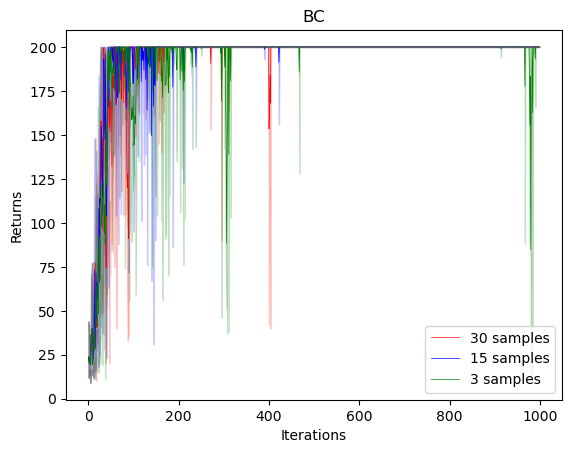

In [18]:
iteration_list = list(range(len(r30_mean)))
plt.plot(iteration_list, r30_mean, label='30 samples', color="red", alpha=1, linewidth=0.5)
plt.fill_between(iteration_list, r30_min, r30_max, alpha=0.2, color="red")
plt.plot(iteration_list, r15_mean, label='15 samples', color="blue", alpha=1, linewidth=0.5)
plt.fill_between(iteration_list, r15_min, r15_max, alpha=0.2, color="blue")
plt.plot(iteration_list, r3_mean, label='3 samples', color="green", alpha=1, linewidth=0.5)
plt.fill_between(iteration_list, r3_min, r3_max, alpha=0.2, color="green")
plt.xlabel('Iterations')
plt.ylabel('Returns')
plt.title("BC")
plt.legend()
plt.show()